# Visualización de Información en Python

> **Autor** \
> Eduardo Graells-Garrido \
> Instituto de Data Science UDD \
> Telefónica I+D Chile \
> egraells@udd.cl \
> @carnby

## Sesión 2: Visualización de Tablas

> **Caso de Estudio** \
> Data Set: Encuesta de Viajes (Origen-Destino) de Santiago, 2012 \
> Diplomado en Data Science UDD

## Introducción

En la sesión anterior cargamos la encuesta origen-destino de Santiago y realizamos un análisis exploratorio, más que dirigido a los datos, enfocado en ver las posibilidades de visualización incorporadas en `pandas` y en las bibliotecas `matplotlib` y `seaborn`.

En esta sesión continuaremos el análisis, esta vez enfocándonos en la unidad de _Visualización de Tablas_ que vimos en el módulo teórico del curso.

### Lo que Haremos 

En este ejercicio:

  1. Cargaremos datos de la encuesta, disponible en el [Portal de Datos del Gobierno](http://datos.gob.cl/dataset/31682), en un DataFrame de `pandas`. 
  2. Utilizaremos gráficos de líneas y de barras para explorar tendencias y agrupaciones en las características de los viajes y de las personas.
  3. Visualizaremos distribuciones con _boxplots_ y visualizaciones similares.
  4. Utilizaremos _heatmaps_ y _clustermaps_ para visualizar una matriz origen-destino de la ciudad.

### Preámbulo

In [1]:
# pandas y seaborn trabajan sobre matplotlib, una biblioteca de bajo nivel.
# el submódulo pyplot contiene métodos que nos permitirán manipular los gráficos.
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# la biblioteca de Machine Learning scikit-learn tiene herramientas que permitirán manipular datos.
from sklearn.preprocessing import normalize, minmax_scale
# esto le indica a Jupyter que los gráficos generados se desplieguen dentro del notebook
%matplotlib inline

# esto configura la apariencia de los gráficos
sns.set(context='notebook', font='Fira Sans', style='white', palette='plasma')

In [2]:
path = './EOD_STGO'

Funciones auxiliares:

In [181]:
import numpy as np

def decode_column(df, fname, col_name, index_col='Id', value_col=None, sep=';', encoding='utf-8', index_dtype=np.float64):
    '''
    param :df: DataFrame del que leeremos una columna.
    param :fname: nombre del archivo que contiene los valores a decodificar.
    param :col_name: nombre de la columna que queremos decodificar.
    param :index_col: nombre de la columna en el archivo @fname que tiene los índices que codifican @col_name
    param :value_col: nombre de la columna en el archivo @fname que tiene los valores decodificados
    param :sep: carácter que separa los valores en @fname. 
    param :encoding: identificación del _character set_ que utiliza el archivo. Usualmente es utf-8, si no funciona,
                     se puede probar con iso-8859-1.
    '''
    if value_col is None:
        value_col = 'value'
        
    values_df = pd.read_csv(fname, sep=sep, index_col=index_col, names=[index_col, value_col], header=0,
                            dtype={index_col: index_dtype}, encoding=encoding)
    
    src_df = df.loc[:,(col_name,)]
    
    return src_df.join(values_df, on=col_name)[value_col]

def normalize_rows(df):
    df = pd.DataFrame(normalize(df, norm='l1'), index=df.index, columns=df.columns)
    return df

def normalize_columns(df):
    df = pd.DataFrame(normalize(df, norm='l1', axis=0), index=df.index, columns=df.columns)
    return df

## Carga de Datos y Exploración

In [5]:
personas = pd.read_csv(path + '/personas.csv', sep=';', decimal=',', index_col='Persona', encoding='utf-8')

In [6]:
personas['Sexo'] = decode_column(personas, path + '/Tablas_parametros/Sexo.csv', 'Sexo')
personas['TramoIngreso'] = decode_column(personas, path + '/Tablas_parametros/TramoIngreso.csv', 'TramoIngreso')
personas['Relacion'] = decode_column(personas,path + '/Tablas_parametros/Relacion.csv', 'Relacion', value_col='relacion')
personas['Ocupacion'] = decode_column(personas,path + '/Tablas_parametros/Ocupacion.csv', 'Ocupacion', value_col='ocupacion')

In [7]:
hogares = pd.read_csv(path + '/Hogares.csv', sep=';', decimal=',', index_col='Hogar', encoding='utf-8')

In [9]:
hogares.head()

,Sector,Zona,Comuna,DirCoordX,DirCoordY,Fecha,DiaAsig,TipoDia,Temporada,NumPer,NumVeh,NumBicAdulto,NumBicNino,Propiedad,MontoDiv,ImputadoDiv,MontoArr,ImputadoArr,IngresoHogar,Factor
Hogar,,,,,,,,,,,,,,,,,,,,
100010,7,786,BUIN,335180.8019,6266420.975,14-04-2013,domingo,2,1,3,1,1,0,2,53000.0,0,100000,0,450845,136.393738
100020,7,785,BUIN,338410.2114,6265607.141,10-04-2013,miércoles,1,1,5,1,3,0,1,NaN,0,120000,0,1019369,73.843597
100030,7,791,BUIN,327863.8248,6257800.086,23-08-2013,viernes,1,1,1,0,0,0,3,NaN,0,70000,0,80000,180.722809
100041,7,791,BUIN,327864.0000,6257800.000,23-08-2013,viernes,1,1,5,0,1,0,1,NaN,0,80000,0,559259,150.379059
100052,7,783,BUIN,338480.8152,6267296.941,08-08-2013,jueves,1,1,3,0,0,0,1,NaN,0,117771,1,710309,122.001518


In [10]:
hogares['Sector'] = decode_column(hogares, path + '/Tablas_parametros/Sector.csv', 'Sector')
hogares['Sector'].value_counts()

Poniente                  3735
Sur-Oriente               3645
Sur                       3329
Oriente                   2753
Norte                     2512
Extensión Sur-Poniente    1292
Centro                     998
Name: Sector, dtype: int64

#### ¿Cuál es la distribución del ingreso en los hogares por Sector?

Una respuesta es utilizar los gráficos de distribución que vimos la sesión anterior, `sns.distplot`:

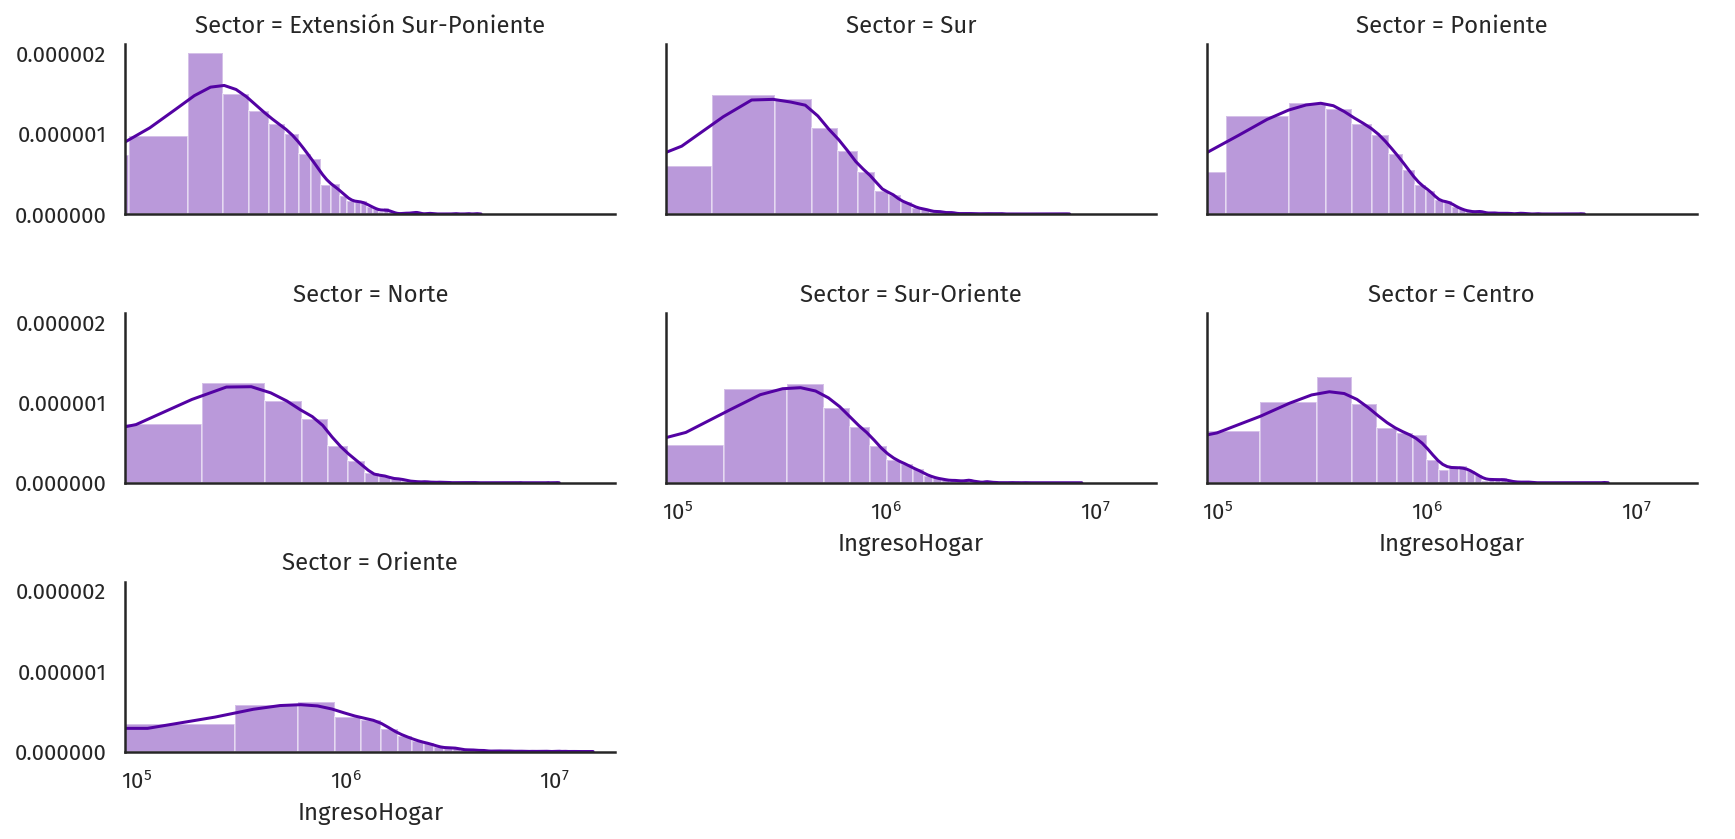

In [11]:
g = sns.FacetGrid(data=hogares, aspect=2, col='Sector', col_wrap=3, height=2, palette='cividis')
g.map(sns.distplot, 'IngresoHogar')
g.set(xscale='log')
g.add_legend()

Sin embargo, son difíciles de interpretar y comparar.

Aquí podemos utilizar `sns.boxplot`:

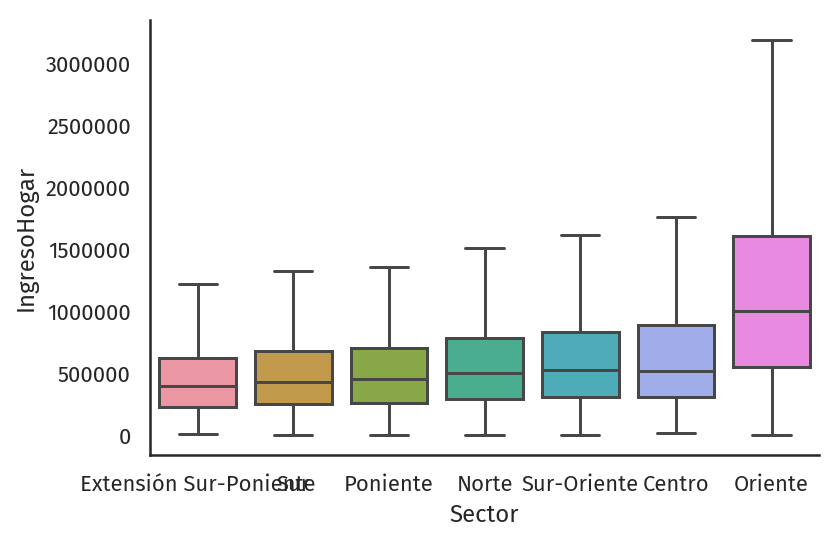

In [12]:
sns.boxplot(x='Sector', y='IngresoHogar', data=hogares, showfliers=False)
sns.despine()

In [13]:
personas_hogar = personas.rename(columns={'Factor': 'FactorPersona'}).join(hogares.rename(columns={'Factor': 'FactorHogar'}), on='Hogar')

In [96]:
viajes = (pd.read_csv(path + '/viajes.csv', sep=';', decimal=',', index_col='Viaje')
          .join(pd.read_csv(path + '/ViajesDifusion.csv', sep=';', index_col='Viaje'))
          .join(pd.read_csv(path + '/DistanciaViaje.csv', sep=';', index_col='Viaje')))
viajes.head()

,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,...,FactorLaboralNormal,FactorSabadoNormal,FactorDomingoNormal,FactorLaboralEstival,FactorFindesemanaEstival,CodigoTiempo,ModoDifusion,DistEuclidiana,DistManhattan,Imputada
Viaje,,,,,,,,,,,,,,,,,,,,,
1734310202,173431,17343102,1,94.0,94.0,2.0,2.0,400,407,335208.7188,...,1.000000,NaN,NaN,NaN,NaN,0.0,2,5387,7608,0
1734410101,173441,17344101,2,94.0,71.0,2.0,3.0,407,307,338536.4375,...,1.127220,NaN,NaN,NaN,NaN,0.0,2,18841,26100,0
1734410102,173441,17344101,2,71.0,94.0,3.0,2.0,307,407,354267.3438,...,1.127220,NaN,NaN,NaN,NaN,0.0,2,18841,26100,0
1734410301,173441,17344103,2,94.0,91.0,2.0,3.0,407,437,338536.4375,...,1.127220,NaN,NaN,NaN,NaN,0.0,2,13392,17589,0
1734410302,173441,17344103,2,91.0,94.0,3.0,2.0,437,407,350841.6563,...,1.052764,NaN,NaN,NaN,NaN,0.0,2,13392,17589,0


In [97]:
viajes['ModoDifusion'] = decode_column(viajes, path + '/Tablas_parametros/ModoDifusion.csv', 'ModoDifusion', encoding='latin-1',
                                       index_col='ID')

In [98]:
viajes['Proposito'] = decode_column(viajes, path + '/Tablas_parametros/Proposito.csv', col_name='Proposito')
viajes['SectorOrigen'] = decode_column(viajes, path + '/Tablas_parametros/Sector.csv', 
                                       col_name='SectorOrigen', index_col='Sector', value_col='Nombre', sep=';')
viajes['SectorDestino'] = decode_column(viajes, path + '/Tablas_parametros/Sector.csv', 
                                       col_name='SectorDestino', index_col='Sector', value_col='Nombre', sep=';')
viajes['ComunaOrigen'] = decode_column(viajes, path + '/Tablas_parametros/Comunas.csv', 'ComunaOrigen', 
                                       value_col='Comuna', sep=',')
viajes['ComunaDestino'] = decode_column(viajes, path + '/Tablas_parametros/Comunas.csv', 'ComunaDestino', 
                                       value_col='Comuna', sep=',')
viajes['Periodo'] = decode_column(viajes, path + '/Tablas_parametros/Periodo.csv', 'Periodo', 
                                  sep=';', value_col='Periodos')

In [99]:
viajes_persona = viajes.drop('Hogar', axis=1).join(personas_hogar, on='Persona')

### ¿A qué hora viaja la gente de acuerdo al propósito del viaje?

In [112]:
viajes_persona = viajes_persona[(viajes_persona['SectorOrigen'] != 'Exterior a RM') 
                & (viajes_persona['SectorDestino'] != 'Exterior a RM')
                & (viajes_persona['SectorOrigen'] != 'Extensión Sur-Poniente') 
                & (viajes_persona['SectorDestino'] != 'Extensión Sur-Poniente')
                & pd.notnull(viajes_persona['SectorOrigen'])
                & pd.notnull(viajes_persona['SectorDestino'])
                & (viajes_persona['Imputada'] == 0)
                & (viajes_persona['DistManhattan'].between(500, 35000))]
len(viajes_persona)

77383

In [122]:
from collections import defaultdict
propositos_agregados = defaultdict(lambda: 'Otro')
propositos_agregados.update({
    'Al estudio': 'Estudio',
    'Al trabajo': 'Trabajo',
    'Por estudio': 'Estudio',
    'Por trabajo': 'Trabajo',
    'volver a casa': 'Volver a Casa',
    'De salud': 'Necesidades',
    'De compras': 'Necesidades',
    'Trámites': 'Necesidades'
})

In [123]:
viajes_persona['PropositoAgregado'] = viajes_persona['Proposito'].map(lambda x: propositos_agregados[x])

/home/egraells/anaconda3/envs/icochan/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


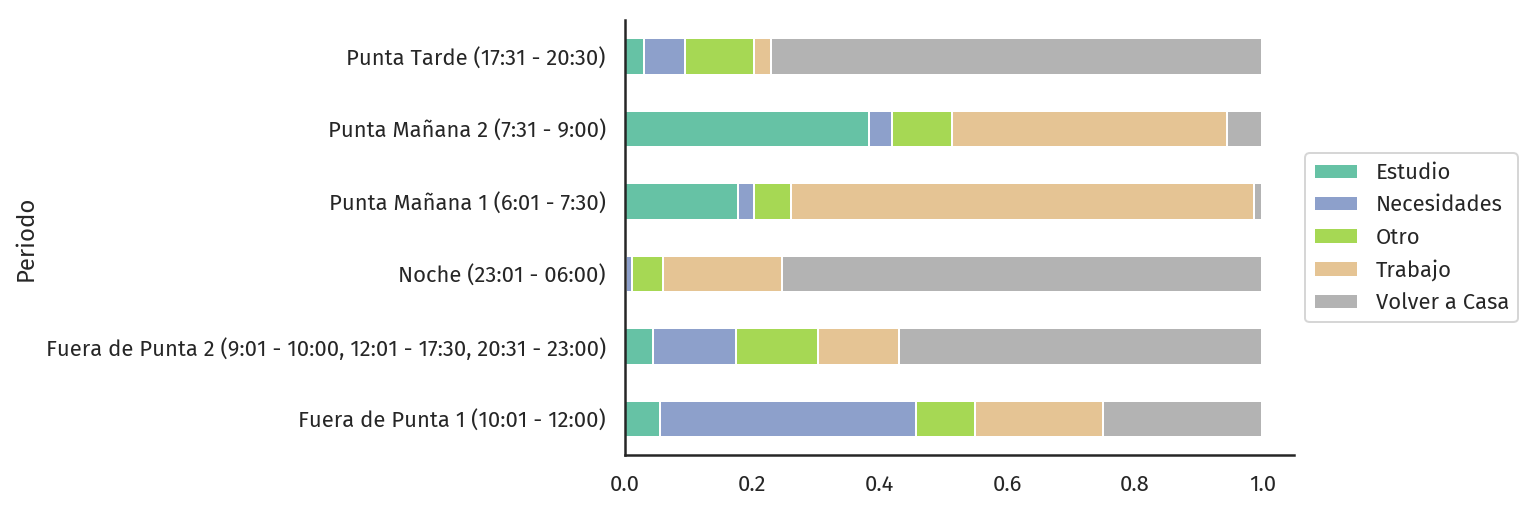

In [138]:
(viajes_persona[pd.notnull(viajes.FactorLaboralNormal)]
 .groupby(['Periodo', 'PropositoAgregado'])
 .apply(lambda x: (x['FactorLaboralNormal'] * x['FactorPersona']).sum())
 .unstack()
 .fillna(0.0)
 .pipe(normalize_rows)
 #.sort_values('Volver a Casa')
 .plot(kind='barh', stacked=True, cmap='Set2')
)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
sns.despine()

In [130]:
viajes_persona['DecilIngreso'] = pd.qcut(viajes_persona['IngresoHogar'], 10)

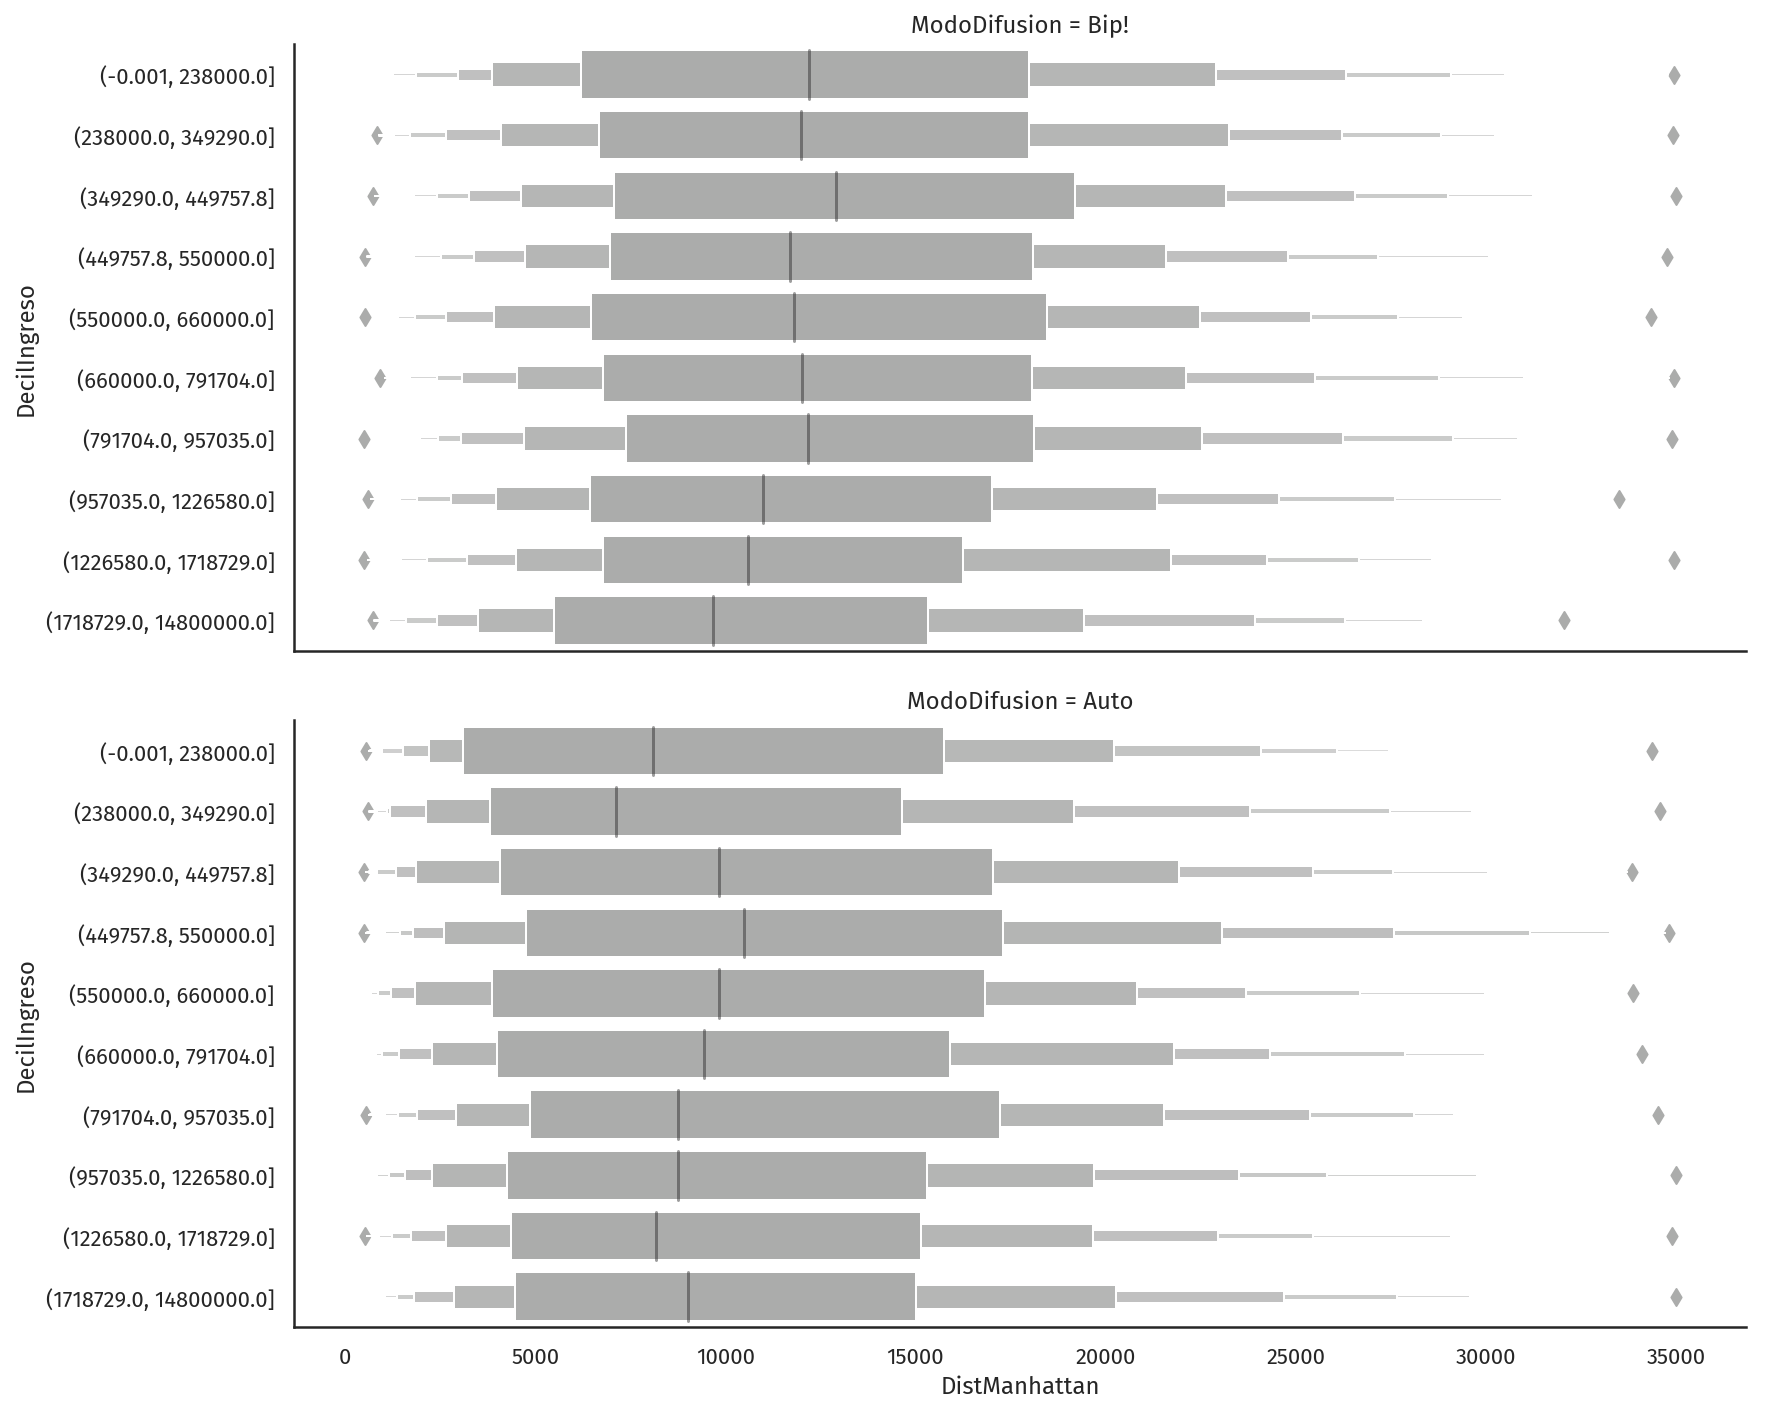

In [131]:
sns.catplot(x='DistManhattan', y='DecilIngreso', row='ModoDifusion', row_order=['Bip!', 'Auto'],
            aspect=2.5, color='#abacab',
            data=viajes_persona[viajes_persona['Proposito'] == 'Al trabajo'],
            kind='boxen')

#### ¿Usan las mujeres los mismos modos de transporte que los hombres?

Para responderla, necesitamos cruzar la tabla de viajes con la tabla de personas. Usaremos el método `merge` de `pandas`:

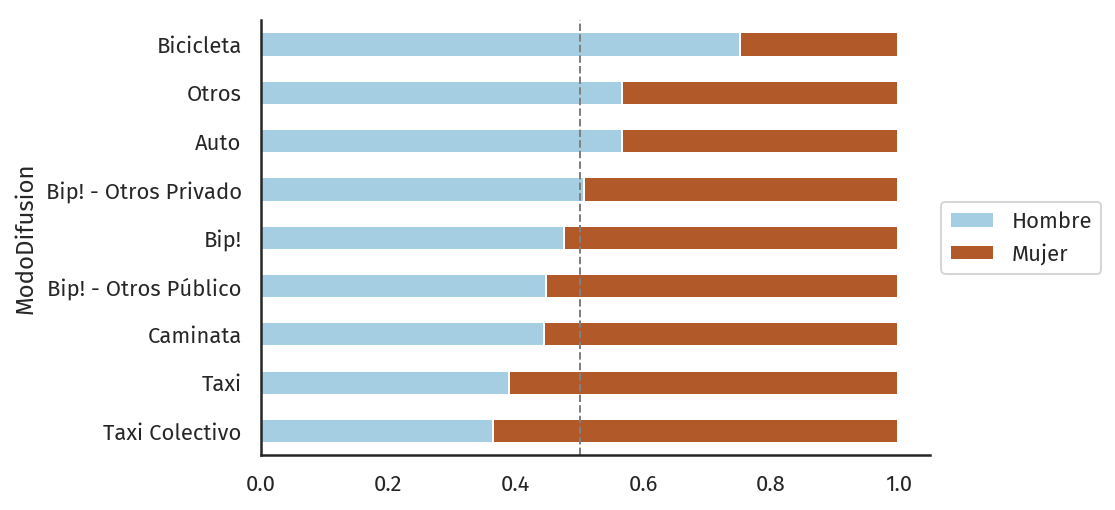

In [157]:
(viajes_persona.groupby(['ModoDifusion', 'Sexo'])
 ['FactorPersona'].sum()
 .unstack()
 .pipe(normalize_rows)
 .sort_values('Hombre')
 .plot(kind='barh', stacked=True, cmap='Paired'))

plt.axvline(x=0.5, color='grey', linestyle='dashed', linewidth=1)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
sns.despine()

#### ¿Quiénes no usan Transantiago y Por qué?

In [186]:
personas_hogar['Edad'] = 2013 - personas_hogar['AnoNac']

In [187]:
personas_hogar['GrupoEtareo'], bins_edad = pd.cut(personas_hogar['Edad'], [0, 18, 25, 35, 45, 55, 65, 120], right=False, retbins=True)
personas_hogar['GrupoEtareo'].value_counts()

[0, 18)      13068
[25, 35)      8575
[65, 120)     8317
[45, 55)      8256
[35, 45)      7942
[18, 25)      7297
[55, 65)      6599
Name: GrupoEtareo, dtype: int64

In [229]:
no_usa_transantiago = (personas_hogar[pd.notnull(personas_hogar.NoUsaTransantiago)]
   ['NoUsaTransantiago']
   .str.split(';')
   .explode()
   .reset_index()
   .assign(NoUsaTransantiago=lambda x: decode_column(x, path + '/Tablas_parametros/NoUsaTransantiago.csv', 'NoUsaTransantiago', index_dtype=str))
   .set_index('Persona')
)

no_usa_transantiago['NoUsaTransantiago'].value_counts()

Utiliza transantiago, pero no lo utilizó el Día de Registro de Viaje por otras razones     21360
No lo utiliza por otra razón (especifique)                                                  9575
Baja frecuencia de los buses                                                                5671
Incómodo (los buses y/o metro van muy llenos)                                               4267
Hay que realizar muchas combinaciones (entre buses y/o Metro)                               2027
Poco seguro (asaltos, hurtos, etc)                                                          1700
Dificultad para calcular los tiempos de viaje (no sabe cuánto demorará en pasar el bus)     1515
Ninguna estación de Metro le queda cerca del origen o destino de sus viajes habituales       604
Name: NoUsaTransantiago, dtype: int64

In [230]:
no_interest = ['Utiliza transantiago, pero no lo utilizó el Día de Registro de Viaje por otras razones',
               'No lo utiliza por otra razón (especifique)']

no_usa_transantiago = (no_usa_transantiago[~no_usa_transantiago.NoUsaTransantiago.isin(no_interest)]
                       .join(personas_hogar[['Sector', 'GrupoEtareo', 'Edad', 'Sexo', 'FactorPersona']]))
no_usa_transantiago.sample(5)

,NoUsaTransantiago,Sector,GrupoEtareo,Edad,Sexo,FactorPersona
Persona,,,,,,
23761102,Baja frecuencia de los buses,Norte,"[35, 45)",43,Hombre,85.90436
14757004,Incómodo (los buses y/o metro van muy llenos),Sur,"[0, 18)",6,Hombre,50.28235
27556102,Ninguna estación de Metro le queda cerca del o...,Centro,"[25, 35)",32,Hombre,225.65633
24542203,Incómodo (los buses y/o metro van muy llenos),Norte,"[25, 35)",26,Mujer,303.68051
26565102,Incómodo (los buses y/o metro van muy llenos),Sur,"[65, 120)",66,Mujer,25.89347


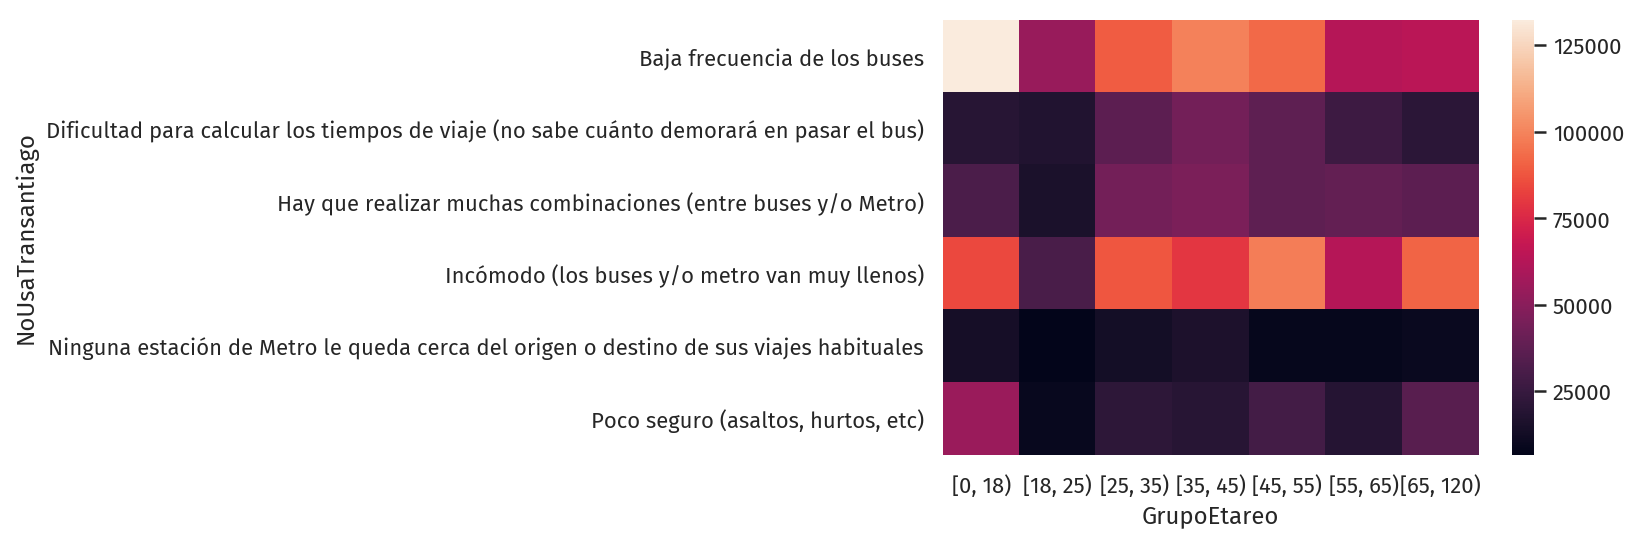

In [231]:
(no_usa_transantiago.groupby(['NoUsaTransantiago', 'GrupoEtareo'])
 ['FactorPersona']
 .sum()
 .unstack()
 .fillna(0)
 .pipe(sns.heatmap))

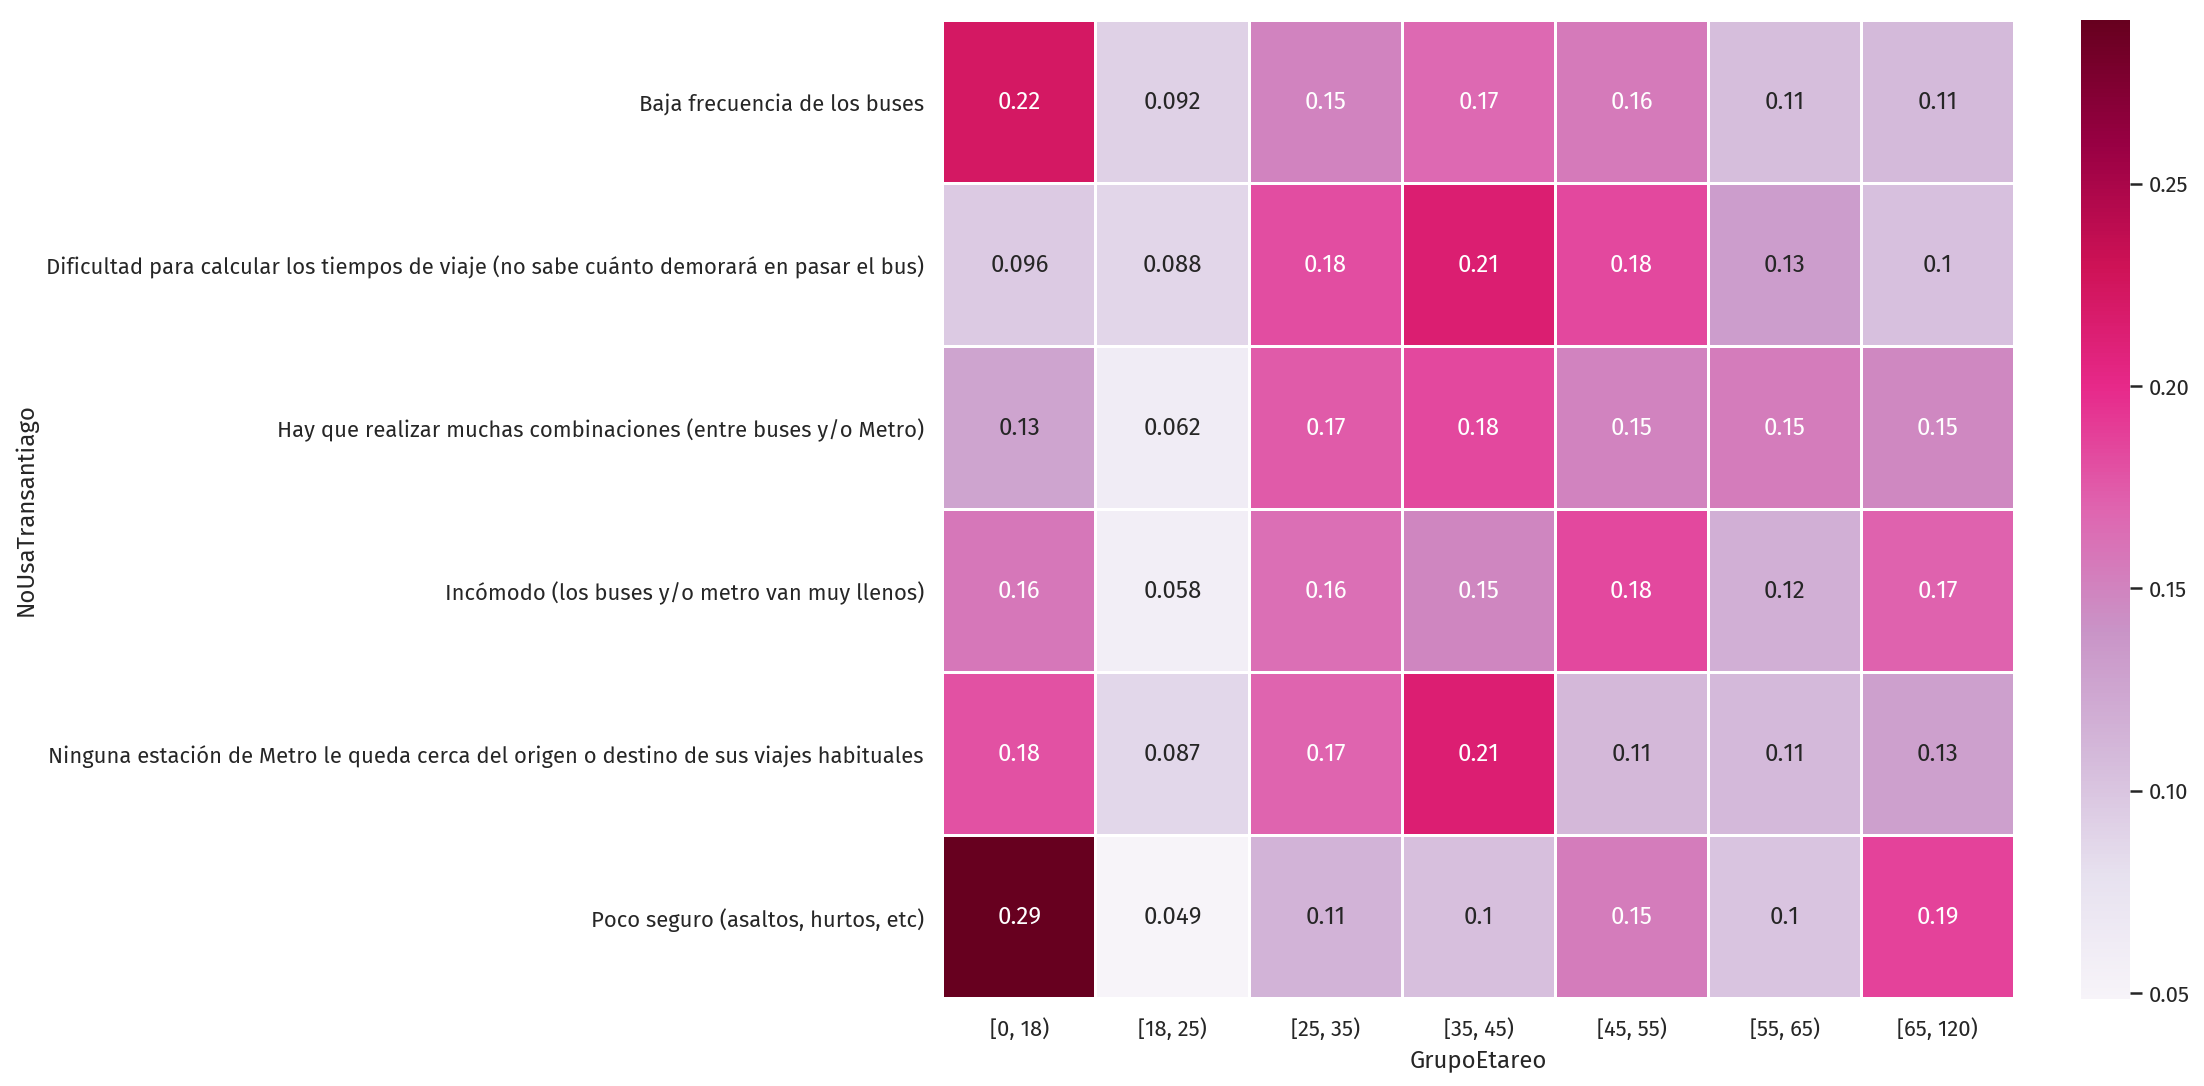

In [232]:
no_uso_por_edad = (no_usa_transantiago.groupby(['NoUsaTransantiago', 'GrupoEtareo'])
 ['FactorPersona']
 .sum()
 .unstack()
 .fillna(0)
 .pipe(normalize_rows))

plt.figure(figsize=(12, 9))
sns.heatmap(no_uso_por_edad, linewidth=1, annot=True, cmap='PuRd')

In [233]:
no_uso_por_sexo = (no_usa_transantiago.groupby(['Sexo', 'NoUsaTransantiago'])
 ['FactorPersona']
 .sum()
 .unstack()
 .fillna(0)
 .pipe(normalize_rows)
 .stack()
 .reset_index()
 # se perdió el nombre de la columna al hacer stack
 .rename(columns={0: 'n_personas'}))

no_uso_por_sexo

,Sexo,NoUsaTransantiago,n_personas
0,Hombre,Baja frecuencia de los buses,0.317373
1,Hombre,Dificultad para calcular los tiempos de viaje ...,0.118091
2,Hombre,Hay que realizar muchas combinaciones (entre b...,0.141981
3,Hombre,Incómodo (los buses y/o metro van muy llenos),0.297496
4,Hombre,Ninguna estación de Metro le queda cerca del o...,0.042027
5,Hombre,"Poco seguro (asaltos, hurtos, etc)",0.083033
6,Mujer,Baja frecuencia de los buses,0.326393
7,Mujer,Dificultad para calcular los tiempos de viaje ...,0.101659
8,Mujer,Hay que realizar muchas combinaciones (entre b...,0.128041
9,Mujer,Incómodo (los buses y/o metro van muy llenos),0.281520


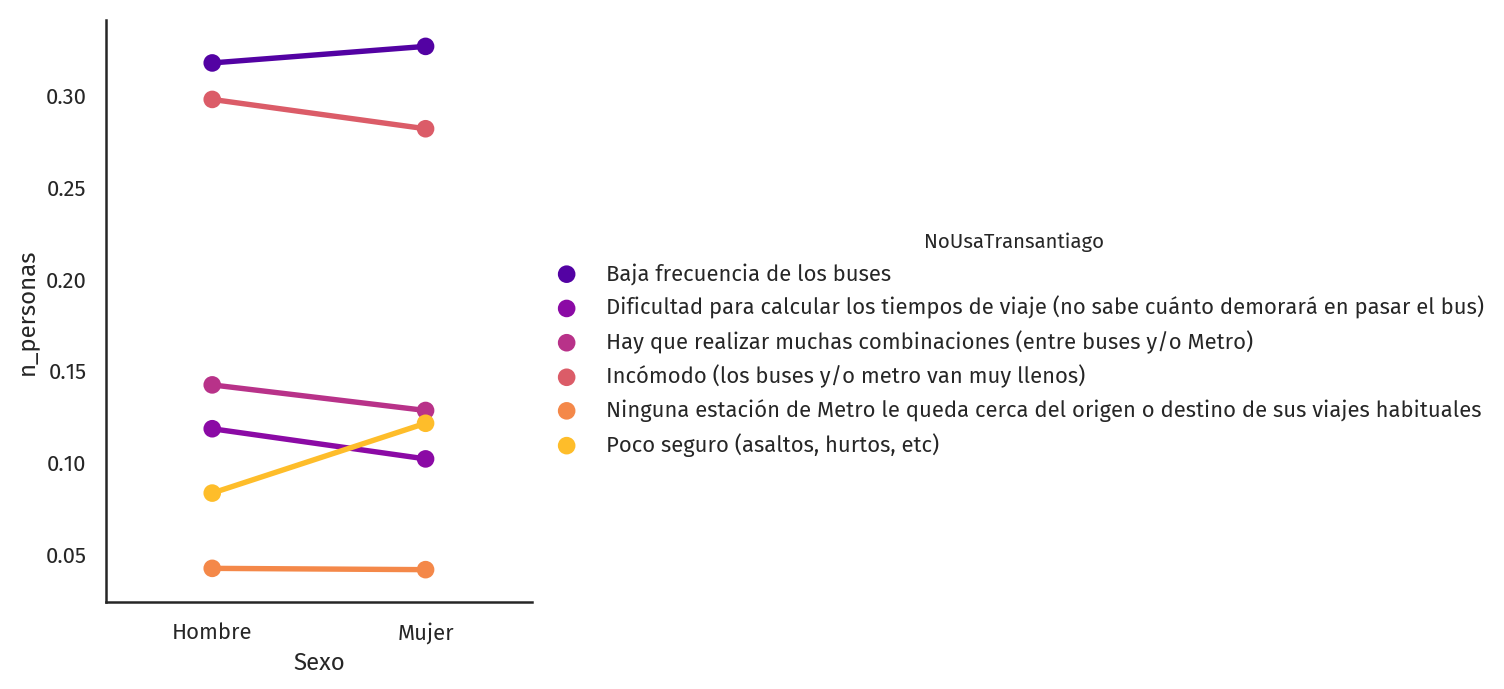

In [234]:
sns.catplot(x='Sexo', y='n_personas', hue='NoUsaTransantiago', data=no_uso_por_sexo, kind='point')

### Flujos entre comunas

Una pregunta que podemos hacernos es encontrar los flujos entre comunas. ¿De dónde hacia dónde se mueve la gente? Para ello no basta con las operaciones que hemos visto, sino que debemos realizar una [agregación](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) a través del método `groupby`. Lo haremos pidiéndole que cuente todos los viajes entre cada combinación posible (de las presentes en los datos) de `ComunaOrigen` y `ComunaDestino`:

In [242]:
flujos = (viajes_persona[pd.notnull(viajes_persona.FactorLaboralNormal) &
                         (viajes_persona.PropositoAgregado.isin(['Estudio', 'Trabajo']))]
          .groupby(['ComunaOrigen', 'ComunaDestino'])
          .apply(lambda x: (x['FactorLaboralNormal'] * x['FactorPersona']).sum())
          .unstack()
          .fillna(0)
          .pipe(normalize_rows))

flujos.sample(3)

ComunaDestino,Calera de Tango,Cerrillos,Cerro Navia,Colina,Conchalí,El Bosque,Estación Central,Huechuraba,Independencia,La Cisterna,...,Quinta Normal,Recoleta,Renca,San Bernardo,San Joaquín,San Miguel,San Ramón,Santiago,Vitacura,Ñuñoa
ComunaOrigen,,,,,,,,,,,,,,,,,,,,,
La Pintana,0.0,0.018434,0.0,0.000696,0.000000,0.024747,0.012392,0.003661,0.000000,0.027882,...,0.000762,0.020852,0.005579,0.025818,0.013428,0.022272,0.034131,0.156016,0.011357,0.033808
Colina,0.0,0.000000,0.0,0.652972,0.000172,0.000000,0.006883,0.000375,0.008306,0.000000,...,0.004787,0.006046,0.000000,0.000000,0.000000,0.000000,0.000000,0.107686,0.000062,0.000000
Lo Espejo,0.0,0.052637,0.0,0.002108,0.000000,0.000000,0.030660,0.004433,0.000000,0.030442,...,0.002885,0.015598,0.000000,0.023607,0.007476,0.027981,0.000000,0.240076,0.001499,0.006487


¿Cómo visualizamos esto? Lo ideal sería tener una matriz, donde las filas son las comunas de origen y las columnas las comunas de destino. Eso es lo que se conoce como **matriz origen-destino**. Para ello debemos hacer una operación llamada `unstack`:

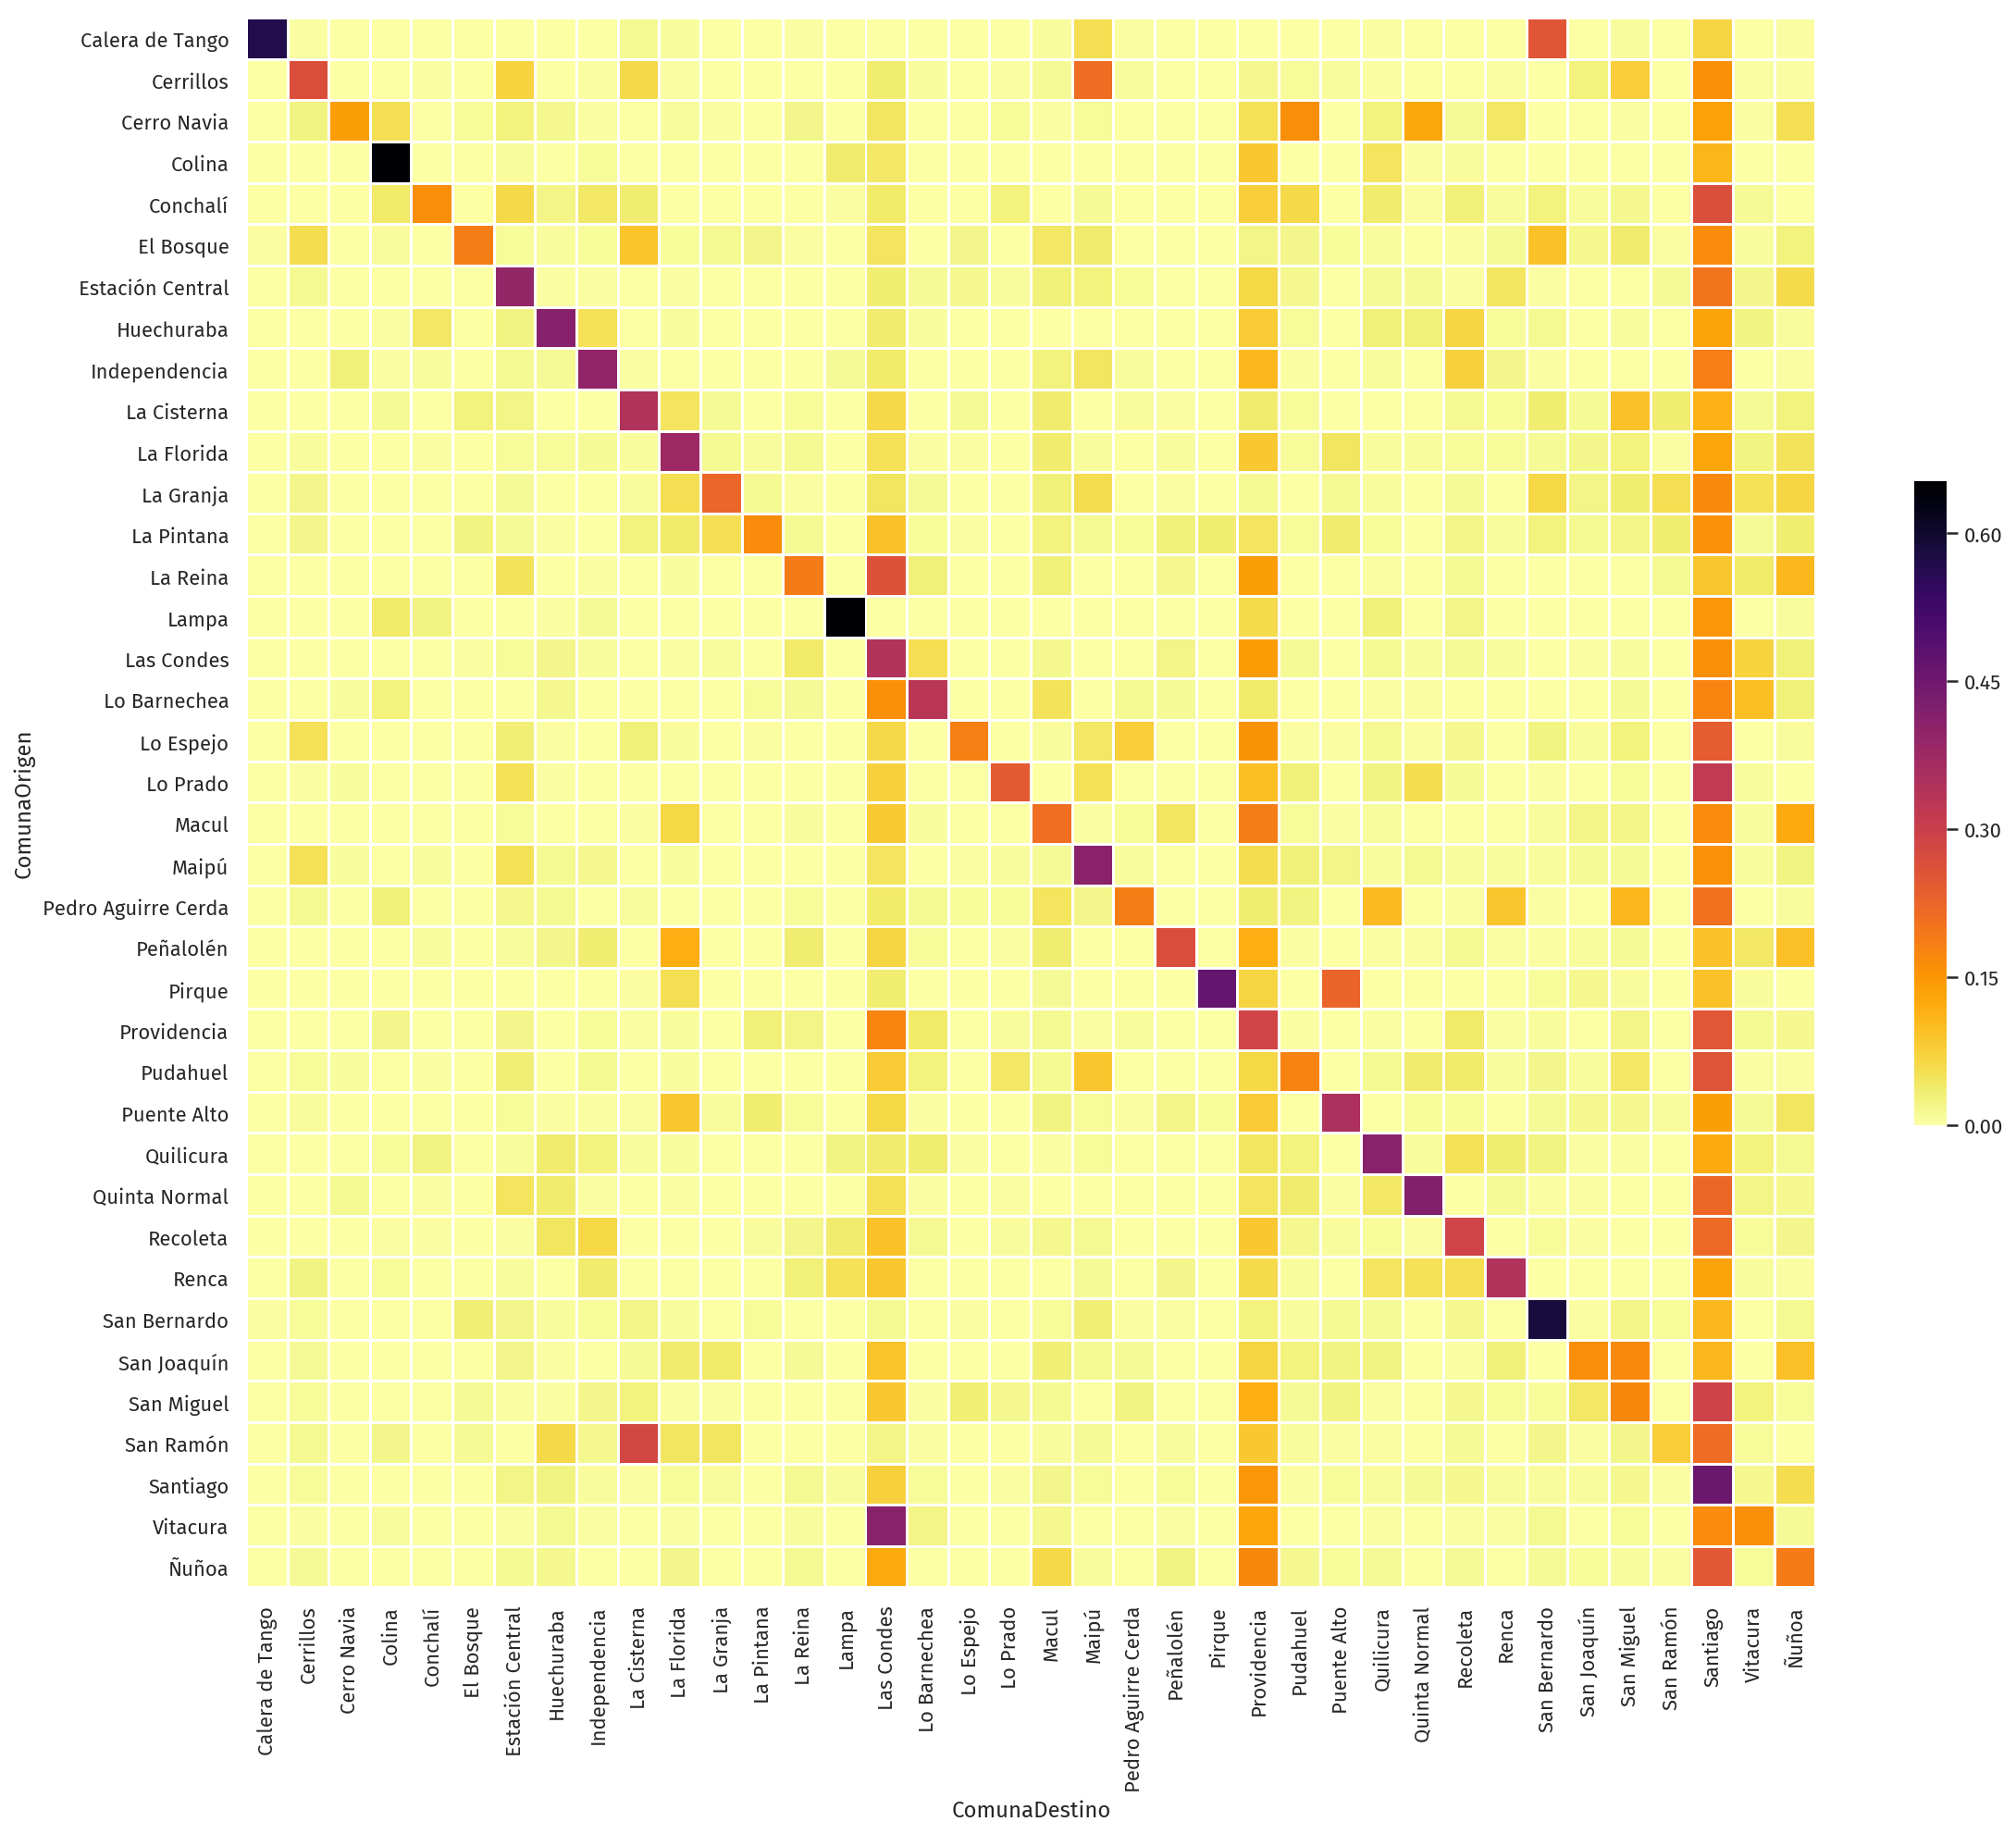

In [243]:
plt.figure(figsize=(19, 16))
sns.heatmap(flujos, cmap='inferno_r', square=True, linewidths=1, cbar_kws={'shrink': 0.4})